In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv("this is killing me.csv")
#dataset.drop('Team' == 'TOT')
team_dataset = dataset.set_index('Tm')
d={}
unique_teams = dataset['Tm'].unique()
for i in unique_teams:
    d[i] = team_dataset.loc[i]

schedule_dataset = pd.read_csv("nba-2018-PacificStandardTime.csv")

In [3]:
team_scores = pd.DataFrame()
for i in unique_teams: 
    team_scores.loc[i, "Points"] = d[i].PTS.sum()/82
    team_scores.loc[i, "Blocks"] = d[i].BLK.sum()/82
    team_scores.loc[i, "Rebounds"] = d[i].TRB.sum()/82
    team_scores.loc[i, "Assists"] = d[i].AST.sum()/82
    team_scores.loc[i, "Turnovers"] = d[i].TOV.sum()/82
    team_scores.loc[i, "Fouls"] = d[i].PF.sum()/82
    team_scores.loc[i, "Free Throws Attempted"] = d[i].FTA.sum()/82
    team_scores.loc[i, "Offensive Rebounds"] = d[i].ORB.sum()/82

    
    
winratio = [.598,.232,.354,.476,.232,.659,.585,.268,.610,.512,.207,
           .646,.402,0,.585,.732,.402,.646,.707,.390,.512,.496,.476
           ,.451,.439,.598,.695,.402,.585,.622,.5]    
team_scores['Win Ratio'] = winratio

In [4]:
hometeam = schedule_dataset.set_index('Home Team')
team_sch_home={}
sch_full = {}
unique_teams2 = schedule_dataset["Home Team"].unique()
for i in unique_teams2:
    team_sch_home[i] = hometeam.loc[i]
    
awayteam = schedule_dataset.set_index('Away Team')
team_sch_away={}
unique_teams3 = schedule_dataset["Away Team"].unique()
for i in unique_teams3:
    team_sch_away[i] = awayteam.loc[i]

In [5]:
##Calculating Player Effiency Rating -- https://www.basketball-reference.com/about/per.html## 
def uPERFunc(MP, PTS, threepoint, AST, team_AST, team_FG , TOV, FGA, FG , FT, FTA , TRB , ORB , STL , BLK , PF):
    #to avoid errors must get rid of zeros##
    list = [MP, PTS, threepoint, AST, team_AST, team_FG , TOV, FGA, FG , FT, FTA , TRB , ORB , STL , BLK , PF]
    
    if MP <= 200 or min(list) == 0: 
        uPER = 0.22 #average
    else:
        factor = (2 / 3) - (0.5 * (math.log(AST) / math.log(FG))) / (2 * (math.log(FG) / math.log(FT)))
        VOP = math.log(PTS) / (math.log(FGA) - math.log(ORB) + math.log(TOV) + 0.44 * math.log(FTA))
        DRBpercent   = (math.log(TRB) - math.log(ORB)) / math.log(TRB)

        uPER = (1 / MP) * ( threepoint + (2/3) * AST + (2 - factor * (team_AST / team_FG)) * FG 
                      + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
                      - VOP * TOV - VOP * DRBpercent * (FGA - FG) - VOP * 0.44 * (0.44 + (0.56 * DRBpercent))
                      * (FTA - FT) + VOP * (1 - DRBpercent) * (TRB - ORB) + VOP * DRBpercent * ORB + VOP * STL
                      + VOP * DRBpercent * BLK - PF * ((math.log(FT) / math.log(PF)) 
                                                       - 0.440 * ( math.log(FTA) / math.log(PF)) * VOP))
    return(uPER*100); 

In [6]:
pd.options.mode.chained_assignment = None ## Getting rid of useless warning##
unique_teams = dataset['Tm'].unique()
for j in unique_teams:
    d[j].fillna(0)
    data = []
    for i in range(len(d[j]['Player'])):
        data.append(uPERFunc(d[j].iloc[i]['MP'],d[j].iloc[i]['PTS'], d[j].iloc[i]['3P%'],d[j].iloc[i]['AST'],
                           d[j]['AST'].sum(), d[j]['FG'].sum(), d[j].iloc[i]['TOV'],
                           d[j].iloc[i]['FGA'],d[j].iloc[i]['FG'],d[j].iloc[i]['FT'], 
                           d[j].iloc[i]['FTA'], d[j].iloc[i]['TRB'],d[j].iloc[i]['ORB'],
                           d[j].iloc[i]['STL'], d[j].iloc[i]['BLK'],d[j].iloc[i]['PF'])) 
    d[j]['PER'] = data

In [7]:
for i in unique_teams:
    team_scores.loc[i, "Alek Rating"] = team_scores.loc[i, "Points"] + (2 * team_scores.loc[i, "Blocks"]) + team_scores.loc[i, "Offensive Rebounds"] -(2 * team_scores.loc[i, "Fouls"]) - (2 * team_scores.loc[i, "Turnovers"]) + team_scores.loc[i, "Assists"]
    team_scores.loc[i,'PER - OFEK'] = d[i]['PER'].mean()

In [8]:
def line_best_fit(x,y):
    m = (((stat.mean(x)*stat.mean(y)) - stat.mean(x*y)) /
         ((stat.mean(x)*stat.mean(x)) - stat.mean(x*x)))
    
    b = stat.mean(y) - m*stat.mean(x)
    
    return m, b

Text(73, 0.7, 'R squared =0.573')

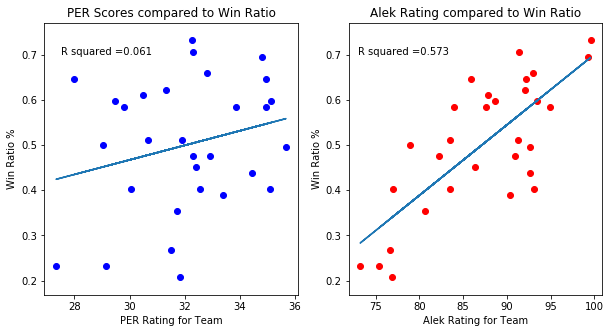

In [9]:
adjusted_team_scores = team_scores.drop('TOT') ## Getting rid of the crazy free agent team##

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplot(1, 2, 1)
X = adjusted_team_scores['PER - OFEK']
Y = adjusted_team_scores['Win Ratio']
m, b = line_best_fit(X,Y)
regression_line = [(m*x)+b for x in X]
plt.scatter(X,Y,color='b')
plt.plot(X, regression_line)
plt.title('PER Scores compared to Win Ratio')
plt.xlabel('PER Rating for Team')
plt.ylabel('Win Ratio %')
plt.annotate('R squared =' + str(round(r2_score(Y, regression_line),3)) , xy= (27.5,0.7))


plt.subplot(1, 2, 2)
X = adjusted_team_scores['Alek Rating']
Y = adjusted_team_scores['Win Ratio']
m, b = line_best_fit(X,Y)
regression_line = [(m*x)+b for x in X]
plt.scatter(X,Y,color='r')
plt.plot(X, regression_line)
plt.title('Alek Rating compared to Win Ratio')
plt.xlabel('Alek Rating for Team')
plt.ylabel('Win Ratio %')
plt.annotate('R squared =' + str(round(r2_score(Y, regression_line),3)) , xy= (73,0.7)) 

In [10]:
division = ['W', 'W', 'E', 'E', 'E', 'W', 'W', 'E', 'W', 'E', 'E', 'W', 'W', 'NA', 'E', 'E', 'W', 'W', 'E', 'E', 'E', 'E', 'W', 'W', 'W', 'E', 'W', 'W', 'W', 'E', 'E']
team_scores['Division'] = division

#team_scores

In [42]:
west = team_scores[team_scores['Division'] == 'W']
west_alek = west.sort_values(by = ['Alek Rating'], ascending = False)
#west_alek[0:8]

In [43]:
west_ofek = west.sort_values(by = ['PER - OFEK'], ascending = False)
#west_ofek[0:8]

In [44]:
east = team_scores[team_scores['Division'] == 'E']
east_alek = east.sort_values(by = ['Alek Rating'], ascending = False)
#east_alek[0:8]

In [45]:
east_ofek = east.sort_values(by = ['PER - OFEK'], ascending = False)
#east_ofek[0:8]

Final Playoff Standings 2018-19:

West:

    Alek: 1. GSW; 2. SAS; 3. NOP; 4. DEN; 5. MIN; 6. POR; 7. SAC; 8. OKC
    
    Ofek: 1. NOP; 2. POR; 3. GSW; 4. MIN; 5. SAS; 6. SAC; 7. DEN; 8. DAL
    
    Actual: 1. GSW; 2. DEN; 3. POR; 4. HOU; 5. UTA; 6. OKC; 7. SAS; 8. LAC
    
East:

    Alek: 1. MIL; 2. BOS; 3. CHO; 4. PHI; 5. TOR; 6. ORL; 7. WAS; 8. IND
    
    Ofek: 1. CHO; 2. BOS; 3. IND; 4. WAS; 5. TOR; 6. MIA; 7. MIL; 8. ORL
    
    Actual: 1. MIL; 2. TOR; 3. PHI; 4. BOS; 5. IND; 6. BRK; 7. ORL; 8. DET

In [52]:
rankedtotalsEastOFEK = east_ofek['PER - OFEK'].to_frame()
rankedtotalsEastOFEK['Ranking Ofek'] = np.arange(len(rankedtotalsEastOFEK))+1
ratingEast = rankedtotalsEastOFEK

rankedtotalsEastALEK= east_alek['Alek Rating'].to_frame()
rankedtotalsEastALEK['Ranking Alek'] = np.arange(len(rankedtotalsEastALEK))+1

for i in rankedtotalsEastOFEK.index:
    ratingEast.loc[i,'Ranking Alek'] = int(rankedtotalsEastALEK.loc[i,'Ranking Alek'])

rankedtotalsWestOFEK = west_ofek['PER - OFEK'].to_frame()
rankedtotalsWestOFEK['Ranking Ofek'] = np.arange(len(rankedtotalsWestOFEK))+1
ratingWest = rankedtotalsWestOFEK

rankedtotalsWestALEK= west_alek['Alek Rating'].to_frame()
rankedtotalsWestALEK['Ranking Alek'] = np.arange(len(rankedtotalsWestALEK))+1

for i in rankedtotalsWestOFEK.index:
    ratingWest.loc[i,'Ranking Alek'] = int(rankedtotalsWestALEK.loc[i,'Ranking Alek'])
    
ratingWest['Actual Standing'] = [3,12,13,10,4,15,14,1,5,2,8,11,7,9,6]
ratingEast['Actual Standing'] = [1,12,8,6,5,14,4,2,3,7,11,10,9,13,15]


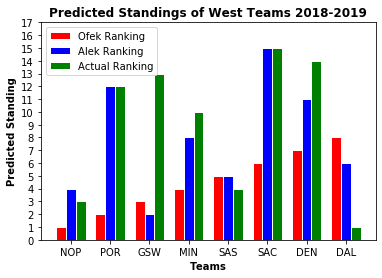

In [53]:
# set width of bar
barWidth = 0.25

# set height of bar
bars1 = ratingWest['Ranking Ofek'][0:8]
bars2 = ratingWest['Ranking Alek'][0:8]
bars3 = ratingWest['Actual Standing'][0:8]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='Ofek Ranking')
plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='Alek Ranking')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='white', label='Actual Ranking')

# Add xticks on the middle of the group bars
plt.xlabel('Teams', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ratingWest.index.values)
plt.yticks(np.arange(0, 18, step=1))
plt.ylabel('Predicted Standing', fontweight='bold')
plt.title('Predicted Standings of West Teams 2018-2019', fontweight = 'bold')
# Create legend & Show graphic
plt.legend()
plt.show()

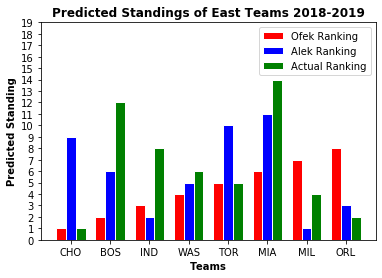

In [54]:
# set width of bar
barWidth = 0.25

# set height of bar
bars1 = ratingEast['Ranking Ofek'][0:8]
bars2 = ratingEast['Ranking Alek'][0:8]
bars3 = ratingEast['Actual Standing'][0:8]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='Ofek Ranking')
plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='Alek Ranking')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='white', label='Actual Ranking')


# Add xticks on the middle of the group bars
plt.xlabel('Teams', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ratingEast.index.values)
plt.yticks(np.arange(0, 20, step=1))
plt.ylabel('Predicted Standing', fontweight='bold')
plt.title('Predicted Standings of East Teams 2018-2019', fontweight = 'bold')
# Create legend & Show graphic
plt.legend()
plt.show()

In [15]:
#predicting for the 2019-20 season based off of their current stats
data_19 = pd.read_csv("nba_19_20_2.csv")

In [16]:
team_19 = data_19.set_index('Tm')
team_19
unique_teams_19 = data_19['Tm'].unique()
team_19_2 = team_19[team_19['G'] > 10]
c = {}
for i in unique_teams_19:
    c[i] = team_19_2.loc[i]
    
for i in unique_teams_19:
    c[i]['Total Min'] = c[i]['MP'] * c[i]['G']

In [17]:
for j in unique_teams_19:
    c[j].fillna(0)
    data = []
    for i in range(len(c[j]['Player'])):
        data.append(uPERFunc(c[j].iloc[i]['Total Min'],c[j].iloc[i]['PTS']*c[j].iloc[i]['G'], c[j].iloc[i]['3P%'],c[j].iloc[i]['AST'],
                           c[j]['AST'].sum()*c[j].iloc[i]['G'], c[j]['FG'].sum()*c[j].iloc[i]['G'], c[j].iloc[i]['TOV']*c[j].iloc[i]['G'],
                           c[j].iloc[i]['FGA']*c[j].iloc[i]['G'],c[j].iloc[i]['FG']*c[j].iloc[i]['G'],c[j].iloc[i]['FT']*c[j].iloc[i]['G'], 
                           c[j].iloc[i]['FTA']*c[j].iloc[i]['G'], c[j].iloc[i]['TRB']*c[j].iloc[i]['G'],c[j].iloc[i]['ORB']*c[j].iloc[i]['G'],
                           c[j].iloc[i]['STL']*c[j].iloc[i]['G'], c[j].iloc[i]['BLK']*c[j].iloc[i]['G'],c[j].iloc[i]['PF']*c[j].iloc[i]['G'])) 
    c[j]['PER'] = data

In [18]:
totals_19 = pd.DataFrame()
for i in unique_teams_19: 
    totals_19.loc[i, "Points"] = c[i].PTS.sum()
    totals_19.loc[i, "Blocks"] = c[i].BLK.sum()
    totals_19.loc[i, "Rebounds"] = c[i].TRB.sum()
    totals_19.loc[i, "Assists"] = c[i].AST.sum()
    totals_19.loc[i, "Turnovers"] = c[i].TOV.sum()
    totals_19.loc[i, "Fouls"] = c[i].PF.sum()
    totals_19.loc[i, "Free Throws Attempted"] = c[i].FTA.sum()
    totals_19.loc[i, "Offensive Rebounds"] = c[i].ORB.sum()
    
for i in unique_teams_19:
    totals_19.loc[i, "Alek Rating"] = totals_19.loc[i, "Points"] + (2 * totals_19.loc[i, "Blocks"]) + totals_19.loc[i, "Offensive Rebounds"] -(2 * totals_19.loc[i, "Fouls"]) - (2 * totals_19.loc[i, "Turnovers"]) + totals_19.loc[i, "Assists"]
    totals_19.loc[i,'PER - OFEK'] = c[i]['PER'].mean()
    
divisions_19 = ['W', 'E', 'W', 'W', 'W', 'E', 'E', 'E', 'W', 'E', 'W', 'W', 'E', 'E', 'W', 'W', 'E', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'W', 'E', 'E', 'W', 'E', 'E']
totals_19['Division'] = divisions_19

#totals_19

In [49]:
west = totals_19[totals_19['Division'] == 'W']
west_alek = west.sort_values(by = ['Alek Rating'], ascending = False)
#west_alek[0:8]

In [48]:
west_ofek = west.sort_values(by = ['PER - OFEK'], ascending = False)
#west_ofek[0:8]

In [47]:
east = totals_19[totals_19['Division'] == 'E']
east_alek = east.sort_values(by = ['Alek Rating'], ascending = False)
#east_alek[0:8]

In [46]:
east_ofek = east.sort_values(by = ['PER - OFEK'], ascending = False)
#east_ofek[0:8]

In [34]:
rankedtotalsEastOFEK = east_ofek['PER - OFEK'].to_frame()
rankedtotalsEastOFEK['Ranking Ofek'] = np.arange(len(rankedtotalsEastOFEK))+1
ratingEast = rankedtotalsEastOFEK

rankedtotalsEastALEK= east_alek['Alek Rating'].to_frame()
rankedtotalsEastALEK['Ranking Alek'] = np.arange(len(rankedtotalsEastALEK))+1

for i in rankedtotalsEastOFEK.index:
    ratingEast.loc[i,'Ranking Alek'] = int(rankedtotalsEastALEK.loc[i,'Ranking Alek'])

rankedtotalsWestOFEK = west_ofek['PER - OFEK'].to_frame()
rankedtotalsWestOFEK['Ranking Ofek'] = np.arange(len(rankedtotalsWestOFEK))+1
ratingWest = rankedtotalsWestOFEK

rankedtotalsWestALEK= west_alek['Alek Rating'].to_frame()
rankedtotalsWestALEK['Ranking Alek'] = np.arange(len(rankedtotalsWestALEK))+1

for i in rankedtotalsWestOFEK.index:
    ratingWest.loc[i,'Ranking Alek'] = int(rankedtotalsWestALEK.loc[i,'Ranking Alek'])
    
ratingWest['Actual Standing'] = [3,12,13,10,4,15,14,1,5,2,8,11,7,9,6]
ratingEast['Actual Standing'] = [1,12,8,6,5,14,4,2,3,7,11,10,9,13,15]

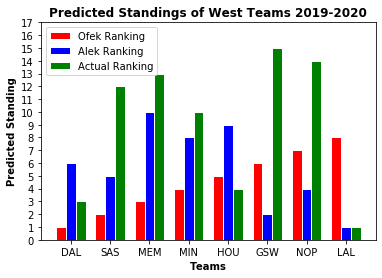

In [41]:
# set width of bar
barWidth = 0.25

# set height of bar
bars1 = ratingWest['Ranking Ofek'][0:8]
bars2 = ratingWest['Ranking Alek'][0:8]
bars3 = ratingWest['Actual Standing'][0:8]

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

 
# Make the plot
plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='Ofek Ranking')
plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='Alek Ranking')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='white', label='Actual Ranking')


 
# Add xticks on the middle of the group bars
plt.xlabel('Teams', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ratingWest.index.values)
plt.yticks(np.arange(0, 18, step=1))
plt.ylabel('Predicted Standing', fontweight='bold')
plt.title('Predicted Standings of West Teams 2019-2020', fontweight = 'bold')
# Create legend & Show graphic
plt.legend()
plt.show()

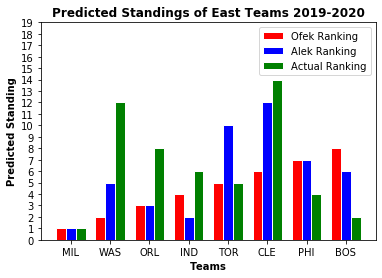

In [40]:
# set width of bar
barWidth = 0.25

# set height of bar
bars1 = ratingEast['Ranking Ofek'][0:8]
bars2 = ratingEast['Ranking Alek'][0:8]
bars3 = ratingEast['Actual Standing'][0:8]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='Ofek Ranking')
plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='Alek Ranking')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='white', label='Actual Ranking')


# Add xticks on the middle of the group bars
plt.xlabel('Teams', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ratingEast.index.values)
plt.yticks(np.arange(0, 20, step=1))
plt.ylabel('Predicted Standing', fontweight='bold')
plt.title('Predicted Standings of East Teams 2019-2020', fontweight = 'bold')
# Create legend & Show graphic
plt.legend()
plt.show()